# Application of Deltas model to Tst

We did not end up using this model for the submission due to a qualitative reasons, but we show the application of it to tst. It produced very good images, but the group decided that the other images were better to show the behaviour of the storm at future times. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

from livelossplot import PlotLosses
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


Using a dataloader instead of direct loading to prevent from overloading memory. The dataloader prevents this from happening, presenting an "on-demand" memory efficient loading of data. It is also well integrated into PyTorch, which simplifies the use with the models.

In our data loader here, we define both a window size (the length of the sequence), prediction size (the number of elements to be predicted) and then batch size. The output will be both X ("training") tensors, which will be of size batch size, Window size - prediction size, 1, 366, 366, and Y, which will be of size batch size, Window size - prediction size, 1, 366, 366. The window will slide linearly, in the sense that there is overlap in all the elements except the first one and last one between subsequent sequences.

In [53]:
class ImageSequenceDataset(Dataset):
    """
    A PyTorch dataset class for loading sequences of images for time series prediction tasks,
    such as forecasting future frames. This dataset provides sequences of images (X) and their 
    corresponding future images (y) based on specified window and prediction sizes.

    Parameters:
        directory (str): The path to the directory containing the image files.
        transform (callable, optional): An optional transform to be applied on each image.
        window_size (int): The total number of images in each sequence, including both input 
                           and prediction frames.
        prediction_size (int): The number of future images to predict at the end of each sequence.

    Each item in the dataset is a tuple (X, y), where X is the sequence of 'window_size - prediction_size'
    input images and y is the sequence of 'prediction_size' future images that follow X.
    """
    def __init__(self, directory, transform=None, window_size=10, prediction_size=3, inference=False):
        self.directory = directory
        self.transform = transform
        self.window_size = window_size
        self.prediction_size = prediction_size
        self.inference = inference

        # List of sorted filenames
        self.filenames = sorted([f for f in os.listdir(directory) if f.endswith('.jpg')])
        
        # Total number of sequences that can be generated given the window and prediction sizes
        self.num_sequences = len(self.filenames) - window_size + 1

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Loads at most just the sequence into memory instead of the whole dataset.
        """
        sequence_images = []

        # Calculate start and end index of the sequence
        start_idx = idx
        end_idx = idx + self.window_size

        # Load and transform each image in the sequence
        for i in range(start_idx, end_idx):
            image_path = os.path.join(self.directory, self.filenames[i])
            image = Image.open(image_path).convert('L')
            if self.transform:
                image = self.transform(image)
            sequence_images.append(image)

        # Convert list of images to tensor
        sequence_tensor = torch.stack(sequence_images)

        # Split the sequence tensor into X (input) and y (target)
        if not self.inference:
            X = sequence_tensor[:self.window_size - self.prediction_size]
            y = sequence_tensor[self.window_size - self.prediction_size:]
        else:
            X = sequence_tensor[self.prediction_size:]
            y = None

        return X, y

The dataset below is the dataset for the deltas model. The difference in this dataset compared to the above is that here, we output the deltas, and then use them to model them with our deep learning model.

For a sequence of length N, it will output N-1 deltas. 

For the sequences in X, the deltas will just be the deltas between each subsequent image (so for the delta in position 1 in the sequence, the delta is the pixel difference between the image in position 2 and position 1). Hence X has length sequence length - prediction size - 1. For a sequence length of 10 and prediction size of 3, you have 7 elements in the sequence of X and hence 6 deltas.

For the sequences in Y, the deltas are the differences between the image in that position and the LAST image in X (as we are not supposed to know the intermediate ones). You have prediction size number of deltas.

In [3]:
class ImageSequenceDatasetDelta(Dataset):
    """
    A dataset class for loading and transforming sequences of image data 
    intended for use in predicting future states of a sequence.

    The dataset generates pairs of image sequences (X) and target delta sequences (y).
    Each sequence X consists of 'window_size' consecutive images, and the corresponding 
    target y is the sequence of 'prediction_size' delta images calculated as the pixel-wise 
    difference from the last image in X to the subsequent images.

    Parameters:
        directory (str): Directory path containing the image files.
        transform (callable, optional): Optional transform to be applied on each image.
        window_size (int): Number of images in each sequence of X.
        prediction_size (int): Number of delta images to predict for each sequence.

    Returns:
        Tuple of Tensors: (X, y) where X is a tensor of input deltas with shape 
        (window_size - 1 - prediction_size, height, width) and y is a tensor of target 
        deltas with shape (prediction_size, height, width).
    """
    def __init__(self, directory, transform=None, window_size=10, prediction_size=3):
        self.directory = directory
        self.transform = transform
        self.window_size = window_size
        self.prediction_size = prediction_size

        # List of sorted filenames
        self.filenames = sorted([f for f in os.listdir(directory) if f.endswith('.jpg')])
        
        # Total number of sequences that can be generated given the window and prediction sizes
        self.num_sequences = len(self.filenames) - window_size + 1

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        sequence_images = []

        # Calculate start and end index of the sequence
        start_idx = idx
        end_idx = idx + self.window_size

        # Load and transform each image in the sequence
        for i in range(start_idx, end_idx):
            image_path = os.path.join(self.directory, self.filenames[i])
            image = Image.open(image_path).convert('L')
            if self.transform:
                image = self.transform(image)
            sequence_images.append(image)

        # Convert list of images to tensor
        sequence_tensor = torch.stack(sequence_images)

        # Compute deltas for X (input deltas)
        X_deltas = [sequence_tensor[i + 1] - sequence_tensor[i] for i in range(self.window_size - 1 - self.prediction_size)]
        X = torch.stack(X_deltas)

        # Compute deltas for y (target deltas) relative to the last image in X sequence
        last_X_image = sequence_tensor[self.window_size - 1 - self.prediction_size]
        y_deltas = [sequence_tensor[self.window_size - self.prediction_size + i] - last_X_image for i in range(self.prediction_size)]
        y = torch.stack(y_deltas)

        return X, y
    
directory = 'Selected_Storms_curated/gkf'

window_size = 10
prediction_size = 3

transform = transforms.Compose([
    transforms.Resize((366, 366)),
    transforms.ToTensor(),
])


We saw that a simple convolutional LSTM worked well. The convolutional layers extract the spatial features that are interesting for the model (swirls, eyes of the storm, etc), and then the LSTM (which we use the pytorch one) will try to capture the sequential nature. We tried implementing a time aware convolutional LSTM, but we could not make it work well. 

We decided not to implement a GAN, VAE, etc for the generation, as they would produce some inherent randomness which is needed in generational models such as those. Thus, the last step outputs the image sizes.

This model works for both the "deltas" and for the original function comparing them directly.

In [4]:
class ConvLSTMModel(nn.Module):
    """
    A convolutional LSTM model that combines convolutional layers
    and an LSTM layer for processing sequential image data.

    The model consists of a series of convolutional layers followed by an
    LSTM layer and a fully connected layer. The convolutional layers extract
    spatial features from each frame in the sequence, while the LSTM layer
    captures temporal dependencies between the frames.
    The output of the LSTM layer is then passed through a fully connected
    layer to generate predictions of image shape for each sequence.

    Attributes:
        conv_layers (nn.Sequential): Convolutional layers for feature extraction from images.
        lstm (nn.LSTM): LSTM layer for capturing temporal relationships between features extracted by convolutional layers.
        fc (nn.Linear): Fully connected layer for mapping LSTM outputs to the desired prediction shape.
        prediction_shape (tuple): Shape of the output predictions.

    Args:
        prediction_shape (tuple): The shape of the output predictions. This should include dimensions for batch size, sequence length, and any spatial dimensions of the output.

    The input to the model should be a 5D tensor with dimensions [batch size, sequence length, channels, height, width].
    """
    def __init__(self, prediction_shape):
        super(ConvLSTMModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.lstm = nn.LSTM(input_size=128 * 45 * 45, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, np.prod(prediction_shape))
        self.prediction_shape = prediction_shape

    def forward(self, x):
        """
        Forward pass of the ConvLSTMModel.

        Args:
            x (Tensor): Input tensor of shape [batch size, sequence length, channels, height, width],
            representing a batch of image sequences.

        Returns:
            Tensor: The model's predictions, reshaped to the specified prediction shape.
        """
        batch_size, seq_len, C, H, W = x.shape
        c_in = x.view(batch_size * seq_len, C, H, W)
        c_out = self.conv_layers(c_in)
        r_in = c_out.view(batch_size, seq_len, -1)
        r_out, _ = self.lstm(r_in)
        r_out2 = self.fc(r_out[:, -1, :])
        return r_out2.view(-1, *self.prediction_shape) 
    
prediction_shape=(prediction_size, 366, 366, 1)
model = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
print(model)

ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)


We take the images from the dataset directly, without doing any data augmentation of the form of flips, rotations, etc. This is because the whole point of the model is to learn the structure of the changes, so if you start adding gaussian rotation or flips, this structure will disappear.

We train on the whole dataset.

In [5]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory='Selected_Storms_curated/tst',
    transform=transform,
    window_size=10,
    prediction_size=3
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

Shape of X in the first batch: torch.Size([2, 7, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])


In [30]:
# Initialize the dataset
dataset_delta = ImageSequenceDatasetDelta(
    directory='Selected_Storms_curated/tst',
    transform=transform,
    window_size=12,
    prediction_size=3
)

# Create a DataLoader
dataloader_delta = DataLoader(dataset_delta, batch_size=2, shuffle=True)

first_batch = next(iter(dataloader_delta))
X_first_delta, y_first_delta = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first_delta.shape}')
print(f'Shape of y in the first batch: {y_first_delta.shape}')

Shape of X in the first batch: torch.Size([2, 8, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])


In here, we define a weighted MSE loss. The basic idea is that it penalizes more the high loss areas. This was done because, for some strange reason, the loss was plateauing and the deltas calculated were always much lower than expected. By adding this, the areas with high loss are penalized.

In [31]:
class WeightedMSELoss(nn.Module):
    """
    Custom weighted mean squared error loss that penalizes larger errors more heavily.

    The loss is calculated by weighting the squared difference between the input and the target.
    Larger differences are given more weight, which is controlled by the `weight_increase` parameter.

    Attributes:
        weight_increase (float): A scaling factor that determines how much larger errors are penalized.
                                 A higher value increases the penalty on larger errors.

    Methods:
        forward(input, target): Computes the weighted mean squared error between input and target.

    Example:
        >>> criterion = WeightedMSELoss(weight_increase=0.5)
        >>> input = torch.randn(3, requires_grad=True)
        >>> target = torch.randn(3)
        >>> loss = criterion(input, target)
        >>> loss.backward()
    """
    
    def __init__(self, weight_increase=1.0):
        """
        Initializes the WeightedMSELoss class with a specified weight increase for larger errors.

        Parameters:
            weight_increase (float): A factor to control the weighting of larger errors. Defaults to 1.0.
        """
        super().__init__()
        self.weight_increase = weight_increase  # Determines how much more to penalize larger errors

    def forward(self, input, target):
        """
        Compute the weighted mean squared error loss.

        Parameters:
            input (Tensor): The predicted values.
            target (Tensor): The ground truth values.

        Returns:
            Tensor: The computed weighted mean squared error loss.
        """
        # Calculate the square of the differences
        diff = input - target
        squared_diff = diff ** 2

        # Weight errors: larger errors are given more weight
        weights = 1 + self.weight_increase * torch.abs(diff)

        # Calculate the weighted mean squared error
        weighted_squared_diff = weights * squared_diff
        loss = torch.mean(weighted_squared_diff)
        return loss


In [46]:
#criterion = nn.MSELoss()
criterion = WeightedMSELoss(weight_increase=0.4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

train_epoch and train both work the same for the deltas and for the direct model, its just that y_batch is different for each, one being the image we have to guess, the other the delta we have to guess.

In [47]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Conducts a single epoch of training on the given model.

    Processes batches from the dataloader, performs forward and backward passes,
    and updates model weights.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        dataloader (DataLoader): Provides batches of data for training.
        criterion (function): Loss function to measure model performance.
        optimizer (Optimizer): Algorithm to update model's weights.
        device (torch.device): The device to run the training on (CPU or GPU).

    Returns:
        float: The average loss over the epoch.
    """
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.view(-1, *prediction_shape))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train(model, dataloader, criterion, optimizer, epochs=10, device=device, plot_losses=False):
    """
    Runs the training process for the specified number of epochs.

    Each epoch involves training the model with data provided by the dataloader,
    calculating loss, and updating the model parameters.

    Optionally, it can plot the training loss after each epoch.

    Parameters:
        model (nn.Module): The neural network model to be trained.
        dataloader (DataLoader): Provides batches of data for training.
        criterion (function): Loss function to measure model performance.
        optimizer (Optimizer): Algorithm to update model's weights.
        epochs (int): Number of epochs to train the model.
        device (torch.device): The device to run the training on (CPU or GPU).
        plot_losses (bool): Flag to turn on live plotting of losses.

    Prints:
        Epoch number and the corresponding average loss.
    """
    liveloss = PlotLosses() if plot_losses else None
    scheduler = StepLR(optimizer, step_size=5, gamma=0.7)
    
    for epoch in range(epochs):
        logs = {}
        avg_loss = train_epoch(model, dataloader, criterion, optimizer, device)
        
        logs['loss'] = avg_loss
        
        # Update the live plot with the latest logs
        if plot_losses:
            liveloss.update(logs)
            liveloss.send()
            
        scheduler.step()
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

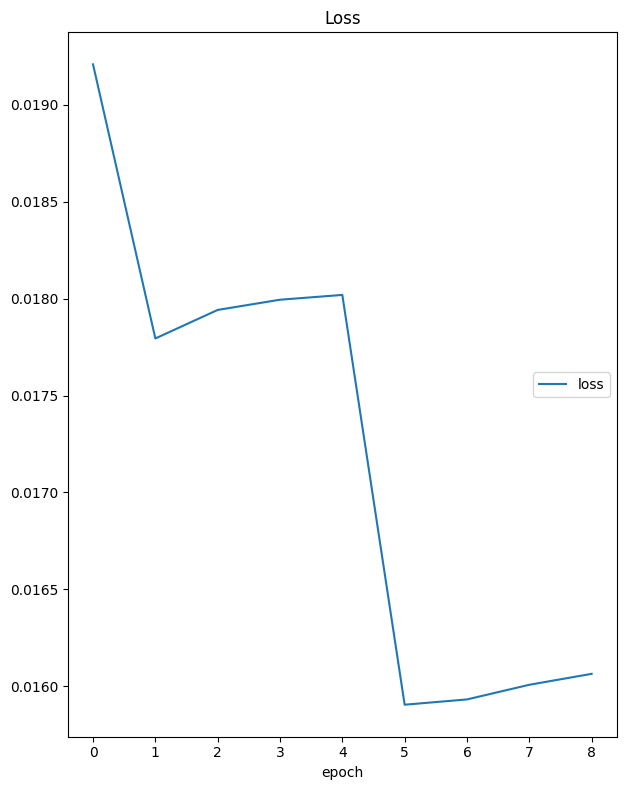

Loss
	loss             	 (min:    0.016, max:    0.019, cur:    0.016)
Epoch 9, Loss: 0.016064577541298797


In [48]:
train(model, dataloader_delta, criterion, optimizer, epochs=9, plot_losses=True)

We now initialize the datasets for inference. This means that we don't define a Y, we define the sequences for X to go all the way to the end.

In [49]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory='Selected_Storms_curated/tst',
    transform=transform,
    window_size=12,
    prediction_size=3,
    inference=True
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

# Initialize the dataset
dataset_delta = ImageSequenceDatasetDelta(
    directory='Selected_Storms_curated/tst_copy',
    transform=transform,
    window_size=12,
    prediction_size=3,
    inference=True
)

# Create a DataLoader
dataloader_delta = DataLoader(dataset_delta, batch_size=2, shuffle=False)

first_batch = next(iter(dataloader_delta))
X_first_delta, y_first_delta = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first_delta.shape}')
print(f'Shape of y in the first batch: {y_first_delta.shape}')

Shape of X in the first batch: torch.Size([2, 9, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])
Shape of X in the first batch: torch.Size([2, 8, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])


This here generates images given a sequence. The training tensor is of shape batch size, input sequence length, 1, 366, 366. This means that, in our case here, to generate new images, we need to give a sequence of images, shape: [1, input sequence length, 1, 366, 366]. As we already have the tensors in our dataloader, we use that.

Given the images, we plot below the input sequence images, the expected deltas, the generated deltas, the generated images (deltas plus the final image in the X sequence), and finally the difference between the generated images and the wanted output images.

In [50]:
def generate_images(model, input_sequence, num_images=3):
    model.eval()
    with torch.no_grad():
        input_sequence = input_sequence.to(device)
        predictions = model(input_sequence)
        # Assume that the model outputs a flattened image sequence, which needs to be reshaped to match the dimensions of the image.
        predictions = predictions.view(-1, num_images, 366, 366, 1)  # Adjust to the shape of the predicted image
        #reverse_normalize(predictions)
        return predictions.cpu().numpy()  
    

def show_images(images, title='Images', figsize=(15, 5), show_colorbar=False, center=False):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:  # If there's only one image
        axes = [axes]
    for img, ax in zip(images, axes):
        # Use CenteredNorm to center the colormap at 0
        if center:
            norm = CenteredNorm(0)
            # Choose a colormap that includes a neutral color in the middle, such as 'RdYlGn', 'coolwarm', or 'seismic'
            im = ax.imshow(img.squeeze(), cmap='seismic', norm=norm)  # 'seismic' colormap has blue-red with white-ish in the middle
        else:
            im = ax.imshow(img.squeeze())  # 'seismic' colormap has blue-red with white-ish in the middle
        ax.axis('off')
        if show_colorbar:
            fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    plt.suptitle(title)
    plt.show()

In [23]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory='Selected_Storms_curated/tst_copy',
    transform=transform,
    window_size=14,
    prediction_size=3
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

# Initialize the dataset
dataset_delta = ImageSequenceDatasetDelta(
    directory='Selected_Storms_curated/tst_copy',
    transform=transform,
    window_size=14,
    prediction_size=3
)

# Create a DataLoader
dataloader_delta = DataLoader(dataset_delta, batch_size=1, shuffle=False)

first_batch = next(iter(dataloader_delta))
X_first_delta, y_first_delta = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first_delta.shape}')
print(f'Shape of y in the first batch: {y_first_delta.shape}')

Shape of X in the first batch: torch.Size([1, 11, 1, 366, 366])
Shape of y in the first batch: torch.Size([1, 3, 1, 366, 366])
Shape of X in the first batch: torch.Size([1, 10, 1, 366, 366])
Shape of y in the first batch: torch.Size([1, 3, 1, 366, 366])


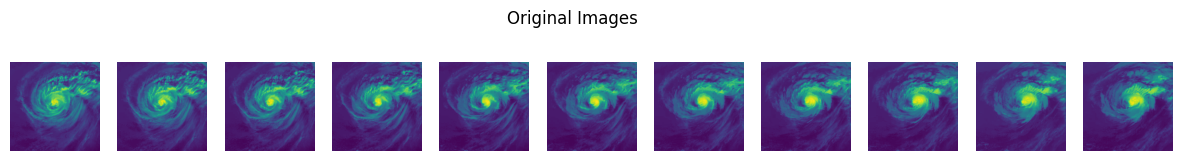

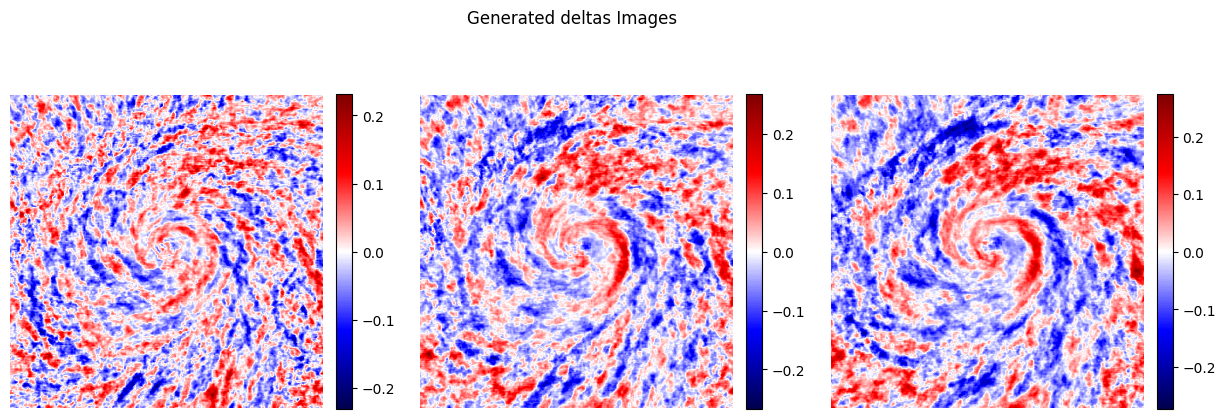

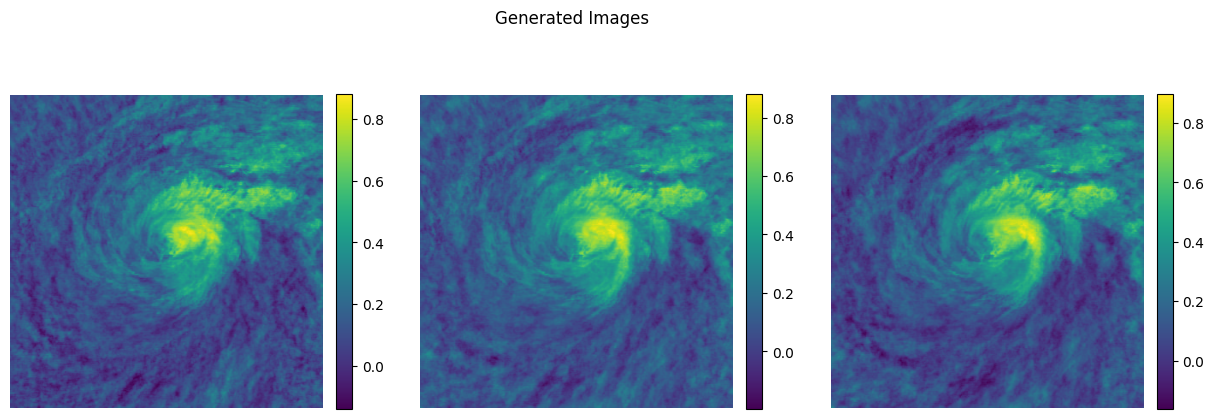

In [24]:
for X_batch_delta, y_batch_delta in dataloader_delta:
    pass  # Simply iterate to the end to get the final batch.

for X_batch, y_batch in dataloader:
    pass  # Simply iterate to the end to get the final batch.

# The last batch is now contained in X_batch and y_batch
last_sequence = X_batch[-1].unsqueeze(0)

last_sequence_delta = X_batch_delta[-1].unsqueeze(0)

# Generate new images from the last sequence
new_images_deltas = generate_images(model, last_sequence_delta, num_images=prediction_size)

# Extract the last image from the last_sequence tensor
last_image = last_sequence[0, -1, 0]  # This selects the last image in the sequence

# Convert the last image to a numpy array and adjust its shape to match new_images_deltas
last_image_np = last_image.cpu().numpy()  # Convert to numpy array (ensure it's moved to CPU if on CUDA)
last_image_np = last_image_np[np.newaxis, :, :, np.newaxis]  # Adjust shape to (1, 366, 366, 1) to match new_images_deltas

# Since new_images_deltas is (1, 3, 366, 366, 1), we can perform the addition directly
# But first, ensure that last_image_np shape matches with new_images_deltas by repeating the last image for the number of deltas
last_image_np_repeated = np.repeat(last_image_np, new_images_deltas.shape[1], axis=0)

generated_images = last_image_np_repeated.squeeze() + new_images_deltas.squeeze()
generated_images = generated_images.squeeze()

# Show the original images from the last input sequence
original_images = last_sequence.squeeze(0).cpu().numpy()  # Remove batch dimension for plotting
show_images([original_images[i] for i in range(original_images.shape[0])], title='Original Images', figsize=(15, 2))

# Display the generated images
generated_deltas_images = new_images_deltas.squeeze(0)  # Remove batch dimension for plotting
show_images([generated_deltas_images[i] for i in range(generated_deltas_images.shape[0])], title='Generated deltas Images', figsize=(15, 5),
             show_colorbar=True, center=True)

# Display the generated images
show_images([generated_images[i] for i in range(generated_images.shape[0])], title='Generated Images', figsize=(15, 5), show_colorbar=True)